Ce notebook traite de la 'feature sélection' des jeux de données des dataframes **train_set** et **test_set** composés des pré-processing (nettoyage, feature engineering)/aggrégations de tous les fichiers mis à notre disposition:

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **Feature selection** : outre la génération de caractéristiques importantes/utiles, il est également essentiel de supprimer les caractéristiques redondantes et bruyantes. Si nous introduisons des déchets/bruits dans notre modèle d'apprentissage automatique, il retournera des déchets/bruits. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques les plus importantes et discriminantes pour notre problématique.

In [30]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV

# Features selection
from boruta import BorutaPy
from BorutaShap import BorutaShap

%run "functions_projet7.ipynb"

# Warnings
warnings.filterwarnings('ignore')

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Lightgbm              : ' + lgb.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.26.4
Pandas                : 2.2.1
Lightgbm              : 4.1.0
Lancé le           : 2024-04-13T10:51:21.294352


In [2]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 5,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

In [3]:
# !conda install --yes --prefix {sys.prefix} BorutaShap

## <span style='background:Thistle'>Chargement des jeux de données</span>

In [4]:
# Répertoire de stockages des fichiers mis à notre disposition
path = 'C:/Users/matis/Desktop/Data_Scientist_OpenClassRooms/Projet_7/'

In [5]:
fic_sav_train_set = path + 'sauvegarde/pre-processing/train_set_preproc.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 616)

In [6]:
fic_sav_test_set = path + 'sauvegarde/pre-processing/test_set_preproc.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 615)

## <span style='background:Thistle'>Features selection</span> 

### <span style='background:PowderBlue'>Features selection : avec LIGHTGBM</span>

<span style='background:Moccasin'>**Train_set/test_set**</span>

In [6]:
# Résumé des variables qualitatives
desc_train_set = description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,nb_nan,%_nan,count,mean,std,min,25%,50%,75%,max
type,int32,int8,int8,int8,int8,int8,int8,float32,float32,float32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SK_ID_CURR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,2.781815e+05,1.027901e+05,1.000020e+05,189146.500000,278203.000000,367143.500000,4.562550e+05
TARGET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,8.072987e-02,2.724203e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
NAME_CONTRACT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,9.520108e-02,2.934930e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CODE_GENDER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,3.416475e-01,4.742628e-01,0.000000e+00,0.000000,0.000000,1.000000,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,5.594630e+06,5.178395e+08,-1.037487e+11,0.024297,0.178888,0.318832,2.233309e+11
BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,-1.263280e+07,1.280215e+09,-4.705600e+11,0.000000,0.000000,0.000000,2.274197e+10
BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,1.892629e+05,6.186877e+05,-1.812124e+07,67771.714844,109743.367188,181750.187500,1.980724e+08
BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,307507.0,5.213990e+04,4.275661e+05,-3.887524e+07,4059.000000,19876.500000,44172.000000,1.422900e+08


In [22]:
# Dataframes de travail
train_lgbm = train_set.copy()
print(f'train_fs_lgbm : {train_lgbm.shape}')
test_lgbm = test_set.copy()
print(f'test_fs_lgbm : {test_lgbm.shape}')

train_fs_lgbm : (307507, 616)
test_fs_lgbm : (48744, 615)


In [23]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_lgbm_labels = train_lgbm['TARGET']

# Sauvegarde des identifiants
train_lgbm_ids = train_lgbm['SK_ID_CURR']
test_lgbm_ids = test_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_lgbm, test_lgbm = train_lgbm.align(test_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_lgbm = train_lgbm.drop(columns=['SK_ID_CURR'])
test_lgbm = test_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_lgbm.shape}')
print(f'test_fs_lgbm : {test_lgbm.shape}')

train_fs_lgbm : (307507, 614)
test_fs_lgbm : (48744, 614)


**Modélisation**

***Premier passage***

In [24]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_sans = np.zeros(train_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [25]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_sans_features, valid_sans_features, train_sans_y, valid_sans_y = \
        train_test_split(train_lgbm, train_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_sans_features, train_sans_y,
              eval_set=[(valid_sans_features, valid_sans_y)],
              eval_metric='auc')

    # Sauvegarde des features importances
    feature_importances_sans += model.feature_importances_

# Moyenne des importances des fonctionnalités sur les deux modèles entraînés
feature_importances_sans /= 2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18668, number of negative: 211962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49728
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 581
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set dat

In [26]:
df_lightgbm = \
    pd.DataFrame({'feature': list(train_lgbm.columns),
                  'importance': feature_importances_sans}) \
    .sort_values('importance', ascending=False)

df_lightgbm.head()

,feature,importance
11,DAYS_REGISTRATION,4152.5
9,DAYS_BIRTH,4094.0
12,DAYS_ID_PUBLISH,3992.0
80,EXT_SOURCE_VAR,3941.0
68,CREDIT_ANNUITY_RATIO,3575.0


In [27]:
# Exploration des variables avec zéro importance
zero_features = \
    list(df_lightgbm[df_lightgbm['importance'] == 0.0][
        'feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

45 variables avec 0.0 importance :



['POS_CASH_NAME_CONTRACT_STATUS_XNA_SUM',
 'FLAG_DOCUMENT_4',
 'PREV_APP_NAME_GOODS_CATEGORY_EDUCATION_SUM',
 'FLAG_DOCUMENT_10',
 'PREV_APP_NAME_GOODS_CATEGORY_DIRECT_SALES_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_TOURISM_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_CANCELED_MEAN',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_7',
 'POS_CASH_NAME_CONTRACT_STATUS_CANCELED_SUM',
 'FLAG_DOCUMENT_2',
 'CCB_NAME_CONTRACT_STATUS_REFUSED_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_AMORTIZED_DEBT_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_ANIMALS_SUM',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_REFUSAL_TO_NAME_THE_GOAL_MEAN',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_8',
 'CCB_NAME_CONTRACT_STATUS_APPROVED_SUM',
 'BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_SUM',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_GARAGE_MEAN',
 'CCB_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_INSURANCE_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_HOUSE_CONSTRUCTION_SUM',
 'FLAG_DOCUMENT_12',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_MEAN',
 'BU

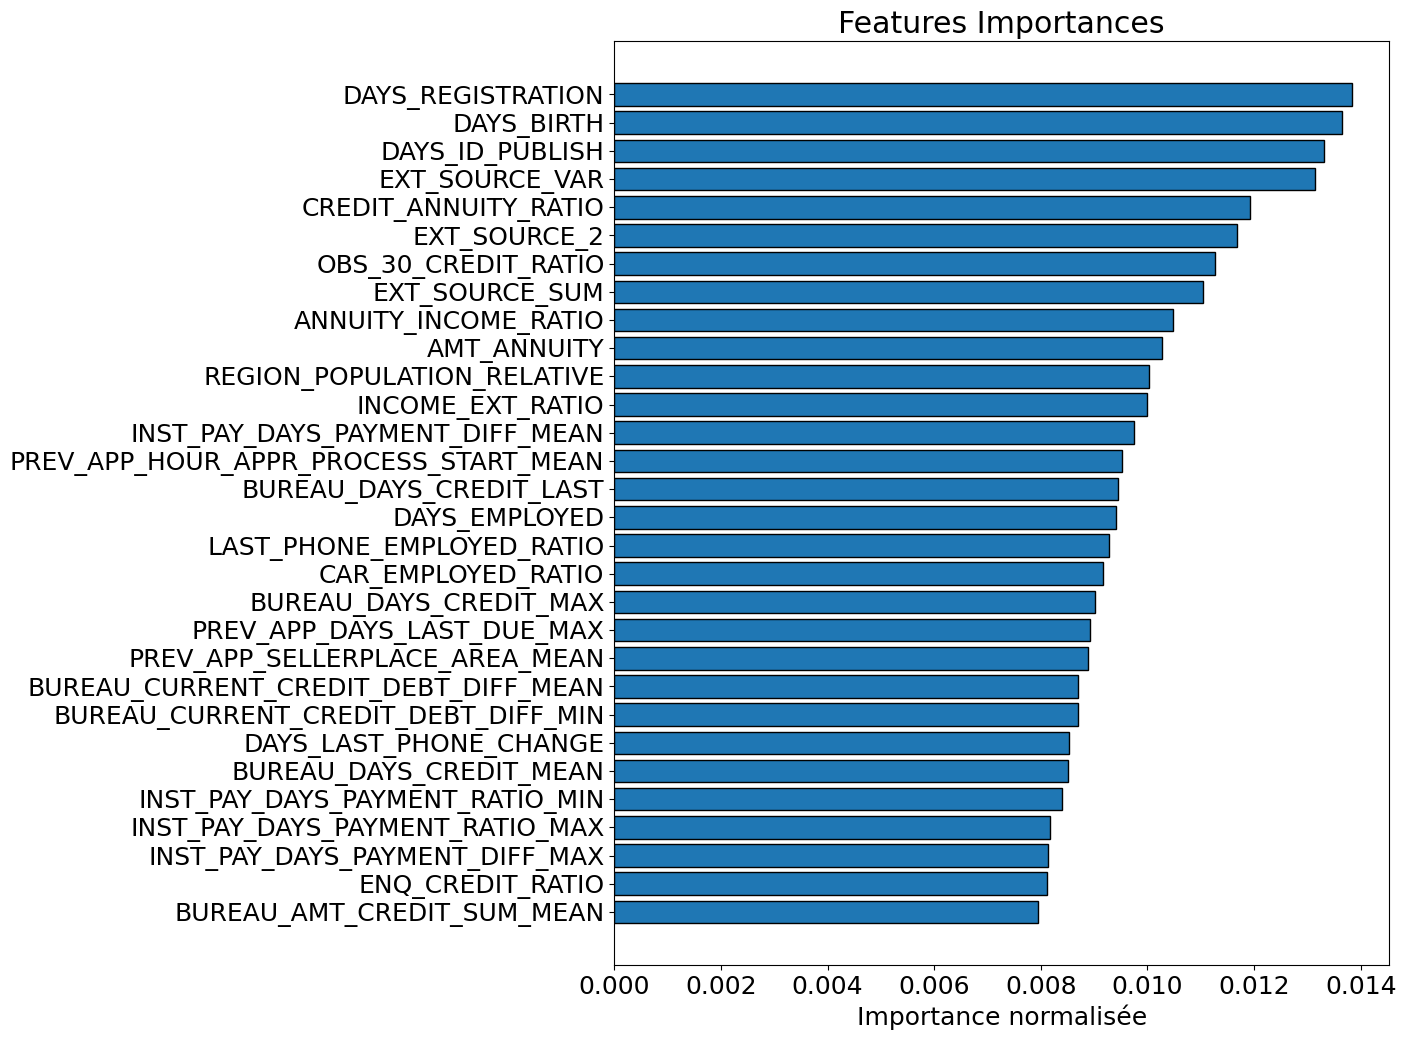

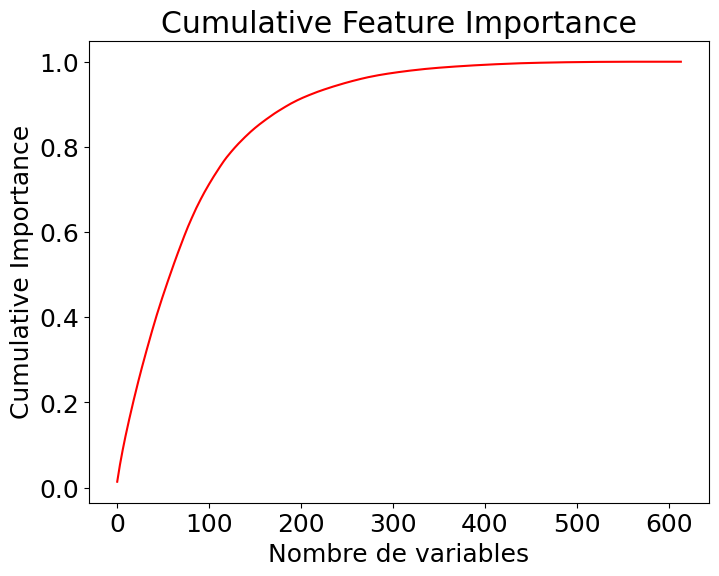

189 variables nécessaires pour 0.90 de cumulative importance


In [28]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_sans_lightgbm_norm = plot_feature_importances(df_lightgbm)

In [29]:
# Suppression des variables avec zéro importance
train_lgbm = train_lgbm.drop(columns=zero_features)
test_lgbm = test_lgbm.drop(columns=zero_features)

print(f'train_lgbm : {train_lgbm.shape}')
print(f'test_lgbm : {test_lgbm.shape}')

train_lgbm : (307507, 569)
test_lgbm : (48744, 569)


In [30]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_lightgbm_2 = identify_zero_importance_features(train_lgbm,
                                       train_lgbm_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18668, number of negative: 211962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49663
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 569
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set dat

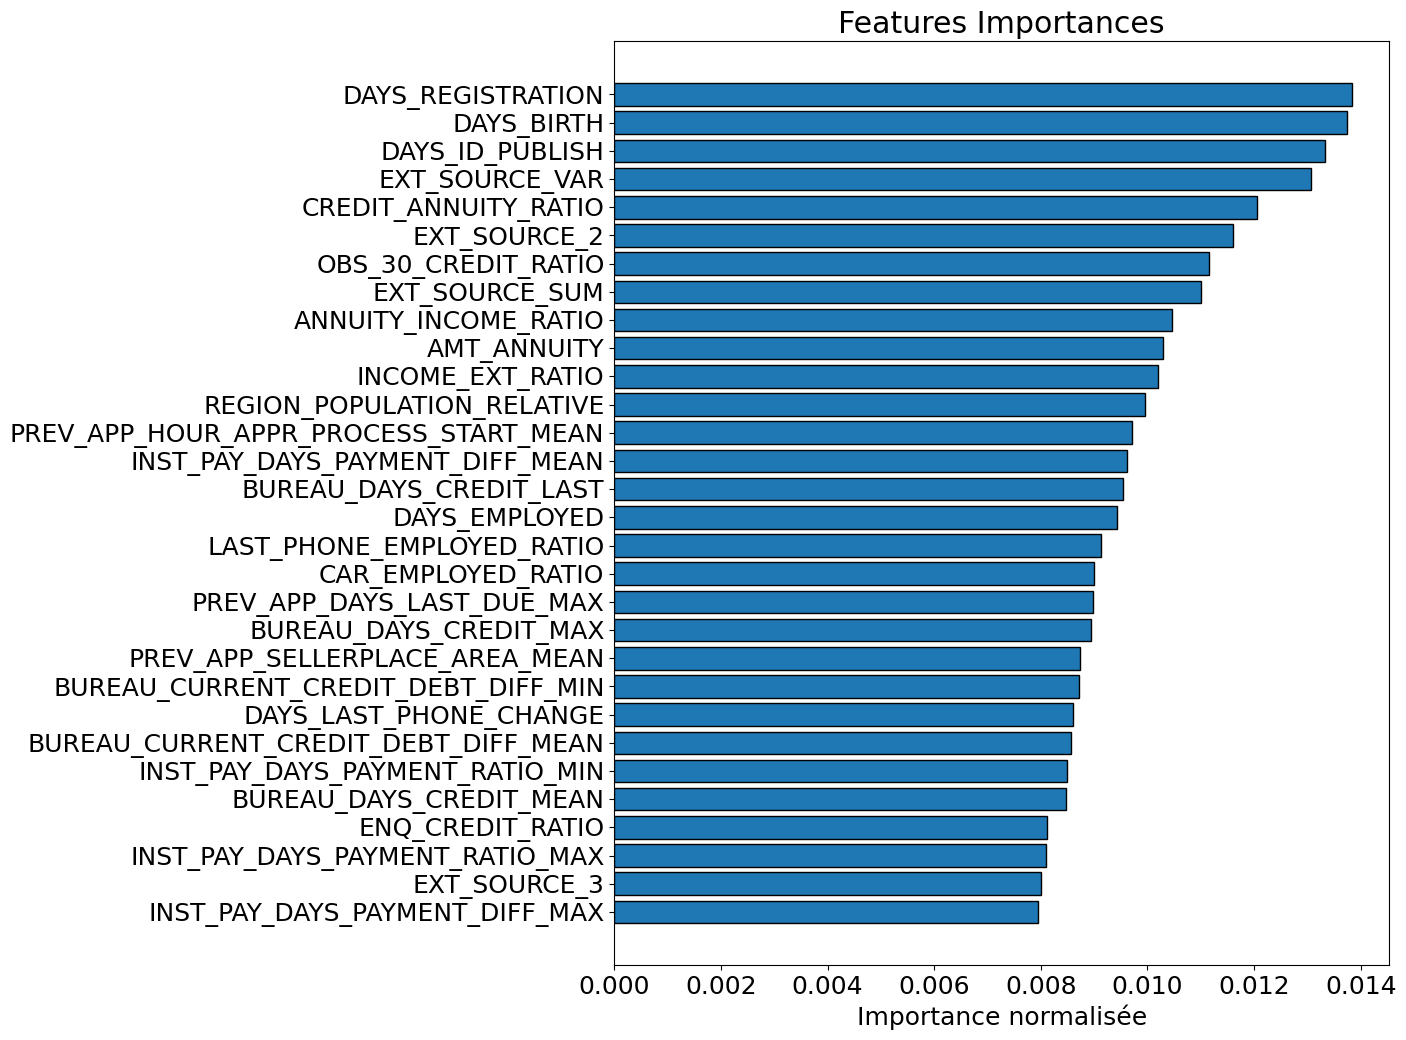

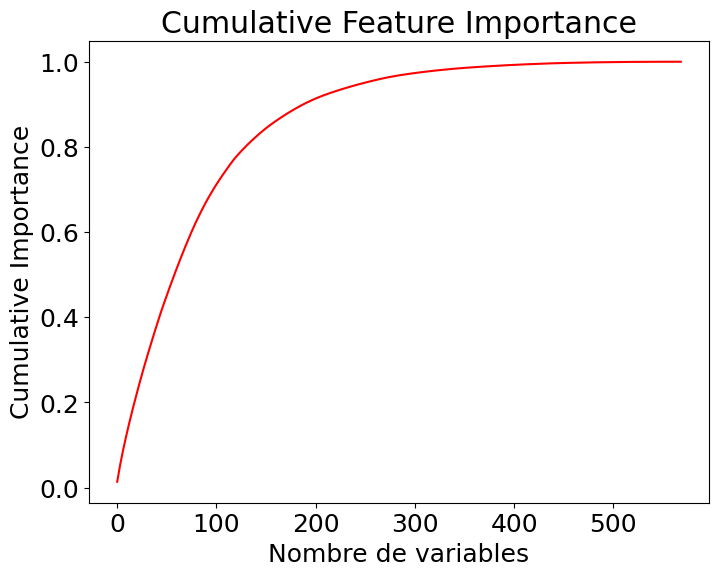

189 variables nécessaires pour 0.90 de cumulative importance


In [31]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_lightgbm_norm_2 = plot_feature_importances(df_lightgbm_2)

In [32]:
# Suppression des variables avec zéro importance
train_lgbm = train_lgbm.drop(columns=zero_features_2)
test_lgbm = test_lgbm.drop(columns=zero_features_2)

print(f'train_lgbm : {train_lgbm.shape}')
print(f'test_lgbm : {test_lgbm.shape}')

train_lgbm : (307507, 565)
test_lgbm : (48744, 565)


In [33]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_3, df_lightgbm_3 = identify_zero_importance_features(train_lgbm,
                                       train_lgbm_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18668, number of negative: 211962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49649
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 565
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set dat

In [36]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_lightgbm = path + 'sauvegarde/features-selection/fs_lightgbm.pickle'
with open(fic_sav_fs_lightgbm, 'wb') as f:
    pickle.dump(df_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

In [21]:
# Chargement des features importance de ligthgbm
fic_sav_fs_lightgbm = path + 'sauvegarde/features-selection/fs_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_lightgbm, 'rb') as df_fs_lightgbm:
    df_fs_lightgbm = pickle.load(df_fs_lightgbm)
df_fs_lightgbm.shape

(565, 2)

In [22]:
# Sauvegarde du nombre de features importance
# df_fs_train_set = pd.DataFrame({})
df_fs_train_set = tracer_features_importance(df_fs_lightgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'lightgbm')

train_set - lightgbm : 565 variables importantes conservées


In [23]:
df_fs_train_set

,Jeu_données,Méthode,Nb_var_importante
0,train_set,boruta-RandomForest,229
1,train_set,borutashap-LightGbm,78
2,train_set,lightgbm,565


### <span style='background:PowderBlue'>Features selection : avec BORUTA</span>

<span style='background:Moccasin'>**Train_set/test_set**</span>

***Avec model RandomForestClassifier***

In [7]:
# Dataframes de travail
train_fs_boruta = train_set.copy()
print(f'train_fs_boruta : {train_fs_boruta.shape}')

train_fs_boruta : (307507, 616)


In [8]:
# Sauvegarde des étiquettes
train_fs_boruta_labels = train_fs_boruta['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta = train_fs_boruta.drop(columns=['SK_ID_CURR'])
train_fs_boruta = train_fs_boruta.drop(columns=['TARGET'])

print(f'train_fs_boruta : {train_fs_boruta.shape}')

train_fs_boruta : (307507, 614)


In [9]:
# Initialisation des variables
X = train_fs_boruta.values
y = train_fs_boruta_labels.values.ravel()

- Ensuite, nous configurons le RandomForestClassifier comme estimateur
à utiliser pour Boruta.
- Le max_depth de l'arbre est conseillé sur la page Github de Boruta pour
être entre 3 et 7.

In [10]:
rf = RandomForestClassifier(n_jobs=-1,
                            class_weight='balanced',
                            max_depth=5)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [11]:
# Initialisation de Boruta
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

boruta_feature_selector = BorutaPy(rf,
                                   n_estimators='auto',
                                   verbose=2,
                                   random_state=21,
                                   max_iter=50,
                                   perc=90)
# Entraînement
boruta_feature_selector.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	614
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	227
Tentative: 	78
Rejected: 	309
Iteration: 	9 / 50
Confirmed: 	227
Tentative: 	78
Rejected: 	309
Iteration: 	10 / 50
Confirmed: 	227
Tentative: 	78
Rejected: 	309
Iteration: 	11 / 50
Confirmed: 	227
Tentative: 	78
Rejected: 	309
Iteration: 	12 / 50
Confirmed: 	228
Tentative: 	77
Rejected: 	309
Iteration: 	13 / 50
Confirmed: 	228
Tentative: 	63
Rejected: 	323
Iteration: 	14 / 50
Confirmed: 	228
Tentative: 	63
Rejected: 	323
Iteration: 	15 / 50
Confirmed: 	228
Tentative: 	63
Rejected: 	323
Iteration: 	16 / 50
Confirmed: 	229
Tent

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=448, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2A8CC4FF140),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x2A8CC4FF140, verbose=2)

In [12]:
# On applique le modèle sur le dataset
X_filtered = boruta_feature_selector.transform(X)
X_filtered.shape

(307507, 229)

In [13]:
# Liste des variables confirmées avec une haute importance
fs_boruta = list()
features = [f for f in train_fs_boruta.columns]
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    fs_boruta.append(features[x])
display(f'fs_boruta : {fs_boruta}')

"fs_boruta : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'NONLIVINGAREA_AVG', 'EMERGENCYSTATE_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'LAST_PHONE_EMPLOYED_RATIO', 'CAR_EMPLOYED_RATIO', 'FLAG_CONTACTS_SUM', 'REGION_RATING_MAX', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'OBS_DEF_30_MUL', 'OBS_30_CREDIT

In [14]:
# Dataframe de features importance avec boruta
df_fs_boruta = pd.DataFrame(fs_boruta)

In [15]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta = path + 'sauvegarde/features-selection/fs_boruta.pickle'
with open(fic_sav_fs_boruta, 'wb') as f:
    pickle.dump(df_fs_boruta, f, pickle.HIGHEST_PROTOCOL)

In [16]:
# Chargement des features importance de boruta
fic_sav_fs_boruta = path + 'sauvegarde/features-selection/fs_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta, 'rb') as df_fs_boruta:
    df_fs_boruta = pickle.load(df_fs_boruta)
df_fs_boruta.shape

(229, 1)

In [17]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame()
df_fs_train_set = tracer_features_importance(df_fs_boruta,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'boruta-RandomForest')

train_set - boruta-RandomForest : 229 variables importantes conservées


### <span style='background:PowderBlue'>Features selection : avec BORUTASHAP</span>

<span style='background:Moccasin'>**Train_set/test_set**</span>

In [20]:
# Dataframes de travail
train_fs_borshap_lgbm = train_set.copy()
print(f'train_fs_borshap_lgbm : {train_fs_borshap_lgbm.shape}')

train_fs_borshap_lgbm : (307507, 616)


In [21]:
# Sauvegarde des étiquettes
train_fs_borshap_lgbm_labels = train_fs_borshap_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_borshap_lgbm = train_fs_borshap_lgbm.drop(columns=['SK_ID_CURR'])
train_fs_borshap_lgbm = train_fs_borshap_lgbm.drop(columns=['TARGET'])

print(f'train_fs_borshap_lgbm : {train_fs_borshap_lgbm.shape}')

train_fs_borshap_lgbm : (307507, 614)


In [22]:
# Initialisation des variables
X = train_fs_borshap_lgbm
y = train_fs_borshap_lgbm_labels

In [23]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          num_boost_round=100)

In [24]:
# Initialisation de BorutaShap
Feature_Selector = BorutaShap(model=lgbm,
                              importance_measure='shap',
                              classification=True)

# Entraînement
Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 17392, number of negative: 197862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.245555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99550
[LightGBM] [Info] Number of data points in the train set: 215254, number of used features: 1163
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> i

In [25]:
# Liste des variables avec une haute importance
fs_borshap_lgbm = Feature_Selector.accepted
fs_borshap_lgbm

['REGION_RATING_MAX',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'CCB_BALANCE_LIMIT_RATIO_MEAN',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'BUREAU_DAYS_CREDIT_MAX',
 'EXT_SOURCE_SUM',
 'FLAG_DOCUMENT_3',
 'CREDIT_ANNUITY_RATIO',
 'DAYS_REGISTRATION',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'EXT_SOURCE_VAR',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN',
 'INST_PAY_DAYS_PAYMENT_RATIO_MEAN',
 'REG_CITY_NOT_LIVE_CITY',
 'YEARS_BEGINEXPLUATATION_AVG',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'NAME_FAMILY_STATUS_MARRIED',
 'INST_PAY_AMT_INSTALMENT_MAX',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'AMT_ANNUITY',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'OWN_CAR

In [26]:
# Dataframe
df_fs_borshap_lgbm = pd.DataFrame(fs_borshap_lgbm)
df_fs_borshap_lgbm.shape

(78, 1)

In [27]:
# Liste des variables à ne pas conserver
cols_to_supp_borutashap = Feature_Selector.features_to_remove
cols_to_supp_borutashap

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG',
       'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'NONLIVINGAREA_AVG', 'EMERGENCYSTATE_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUR

In [28]:
# Sauvegarde du feature selector avec borutashap
fic_sav_fSelector_borshap_lgbm = path + 'sauvegarde/features-selection/features_selector_borshap_lgbm.pickle'
with open(fic_sav_fSelector_borshap_lgbm, 'wb') as f:
    pickle.dump(Feature_Selector, f, pickle.HIGHEST_PROTOCOL)

In [29]:
# Sauvegarde des features importances avec borutashap
fic_sav_fs_borshap_lgbm = path + 'sauvegarde/features-selection/fs_borshap_lgbm.pickle'
with open(fic_sav_fs_borshap_lgbm, 'wb') as f:
    pickle.dump(df_fs_borshap_lgbm, f, pickle.HIGHEST_PROTOCOL)

In [18]:
# Chargement des features importance de borutashap
fic_sav_fs_borshap_lgbm = path + 'sauvegarde/features-selection/fs_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_borshap_lgbm, 'rb') as df_fs_borshap_lgbm:
    df_fs_borshap_lgbm = pickle.load(df_fs_borshap_lgbm)
df_fs_borshap_lgbm.shape

(78, 1)

In [19]:
# Sauvegarde du nombre de features importance
df_fs_train_set = tracer_features_importance(df_fs_borshap_lgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'borutashap-LightGbm')
df_fs_train_set

train_set - borutashap-LightGbm : 78 variables importantes conservées


,Jeu_données,Méthode,Nb_var_importante
0,train_set,boruta-RandomForest,229
1,train_set,borutashap-LightGbm,78


### <span style='background:PowderBlue'>Bilan - Jeux de données finaux</span>

<span style='background:Moccasin'>**Train_set/test_set**</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les librairies Boruta et BorutaShap, les permutations importances avec les librairies scikit-learn ou eli5 et RFECV pour le jeu de données train set sont :
- [x] df_fs_lightgbm,
- [x] df_fs_boruta,
- [x] df_fs_borshap_lgbm

**Répétitions des variables conservées**

In [24]:
# Récupération des variables conservées pour chaque feature selection
liste_var = df_fs_lightgbm['feature'].to_list()
print(len(liste_var))
liste_var.extend(df_fs_boruta[0].to_list())
print(len(liste_var))
liste_var.extend(df_fs_borshap_lgbm[0].to_list())
print(len(liste_var))

565
794
872


In [26]:
# Nomre de répétitions de chacune des variables
from collections import Counter
dico_nbre_repet_var = Counter(liste_var)
len(dico_nbre_repet_var)

565

In [27]:
df_nbr_repet_var = pd.DataFrame.from_dict(dico_nbre_repet_var,
                                          orient='index',
                                          columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)
df_nbr_repet_var

,Variables,Nbr_repetition
0,DAYS_REGISTRATION,3
53,CREDIT_GOODS_RATIO,3
61,PREV_APP_INTEREST_SHARE_MEAN,3
60,PREV_APP_AMT_ANNUITY_MEAN,3
58,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,3
...,...,...
330,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN,1
328,NAME_FAMILY_STATUS_WIDOW,1
326,ORGANIZATION_TYPE_KINDERGARTEN,1
324,POS_CASH_NAME_CONTRACT_STATUS_APPROVED_MEAN,1


In [31]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
distribution_variables_plages(df_nbr_repet_var,
                                          'Nbr_repetition',
                                          liste_bins)

,Plage,nb_données,%_données
0,"(0, 1]",335,59.29204
1,"(1, 2]",153,27.07965
2,"(2, 3]",77,13.62832
3,"(3, 4]",0,0.00000
4,"(4, 5]",0,0.00000
5,"(5, 6]",0,0.00000
6,"(6, 7]",0,0.00000
7,"(7, 8]",0,0.00000


In [36]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set = df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] >= 2][
        'Variables'].to_list()
print(f'{len(var_cons_train_set)} variables conservées pour le train_set')
var_cons_train_set

230 variables conservées pour le train_set


['DAYS_REGISTRATION',
 'CREDIT_GOODS_RATIO',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'NAME_INCOME_TYPE_STATE_SERVANT',
 'PREV_APP_INTEREST_SHARE_MAX',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'REGION_RATING_MAX',
 'INST_PAY_DAYS_INSTALMENT_MIN',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'PREV_APP_AMT_ANNUITY_MIN',
 'FLAGS_DOCUMENTS_SUM',
 'EXT_SOURCE_1',
 'YEARS_BEGINEXPLUATATION_AVG',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'POS_CASH_CNT_INSTALMENT_MEAN',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_3',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'BUREAU_AMT_CR

In [37]:
# Sauvegarde des variables conservées pour le train_set
fic_sav_var_cons_train_set = path + 'sauvegarde/features-selection/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'wb') as f:
    pickle.dump(var_cons_train_set, f, pickle.HIGHEST_PROTOCOL)

In [38]:
# Chargement des variables conservées pour le train_set
fic_sav_var_cons_train_set = path + 'sauvegarde/features-selection/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'rb') as df_var_cons_train_set:
    var_cons_train_set = pickle.load(df_var_cons_train_set)
len(var_cons_train_set)

230

**Test en ne conservant que les variables les plus sélectionnées par feature selection**

In [39]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set_small = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] == 3][
        'Variables'].to_list()
print(f'{len(var_cons_train_set_small)} variables conservées pour le train_set')
var_cons_train_set_small

77 variables conservées pour le train_set


['DAYS_REGISTRATION',
 'CREDIT_GOODS_RATIO',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'NAME_INCOME_TYPE_STATE_SERVANT',
 'PREV_APP_INTEREST_SHARE_MAX',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'REGION_RATING_MAX',
 'INST_PAY_DAYS_INSTALMENT_MIN',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'PREV_APP_AMT_ANNUITY_MIN',
 'FLAGS_DOCUMENTS_SUM',
 'EXT_SOURCE_1',
 'YEARS_BEGINEXPLUATATION_AVG',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'POS_CASH_CNT_INSTALMENT_MEAN',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_3',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'BUREAU_AMT_CR

In [40]:
# Sauvegarde des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = path + 'sauvegarde/features-selection/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'wb') as f:
    pickle.dump(var_cons_train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [41]:
# Chargement des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = path + 'sauvegarde/features-selection/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'rb') as df_var_cons_train_set_small:
    var_cons_train_set_small = pickle.load(df_var_cons_train_set_small)
len(var_cons_train_set_small)

77

**Constitution des dataframes train_set et test_set finaux**

In [42]:
# Constitution du train_set
print(f'{train_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_avec_target_id.extend(var_cons_train_set)
train_set = train_set[var_cons_train_set_avec_target_id]
print(f'{train_set.shape}')

(307507, 616)
(307507, 232)


In [43]:
# Constitution du test_set
print(f'{test_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_avec_id = ['SK_ID_CURR']
var_cons_train_set_avec_id.extend(var_cons_train_set)
test_set = test_set[var_cons_train_set_avec_id]
print(f'{test_set.shape}')

(48744, 615)
(48744, 231)


In [44]:
# Constitution du train_set réduit
train_set_small = train_set.copy()
print(f'{train_set_small.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_small_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_small_avec_target_id.extend(var_cons_train_set_small)
train_set_small = train_set_small[var_cons_train_set_small_avec_target_id]
print(f'{train_set_small.shape}')

(307507, 232)
(307507, 79)


In [45]:
# Constitution du test_set réduit
test_set_small = test_set.copy()
print(f'{test_set_small.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_small_avec_id = ['SK_ID_CURR']
var_cons_train_set_small_avec_id.extend(var_cons_train_set_small)
test_set_small = test_set_small[var_cons_train_set_small_avec_id]
print(f'{test_set_small.shape}')

(48744, 231)
(48744, 78)


In [46]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set = path + 'sauvegarde/features-selection/train_set.pickle'
with open(fic_sav_train_set, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [47]:
# Export en fichier .csv
train_set.to_csv(path + 'data/train_set.csv', index=False)

In [48]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set = path + 'sauvegarde/features-selection/test_set.pickle'
with open(fic_sav_test_set, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

In [49]:
# Export en fichier .csv
test_set.to_csv(path + 'data/test_set.csv', index=False)

In [50]:
# Sauvegarde du train_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_small = path + 'sauvegarde/features-selection/train_set_small.pickle'
with open(fic_sav_train_set_small, 'wb') as f:
    pickle.dump(train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [51]:
# Export en fichier .csv
train_set_small.to_csv(path + 'data/train_set_small.csv', index=False)

In [52]:
# Sauvegarde du test_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_small = path + 'sauvegarde/features-selection/test_set_small.pickle'
with open(fic_sav_test_set_small, 'wb') as f:
    pickle.dump(test_set_small, f, pickle.HIGHEST_PROTOCOL)

In [53]:
# Export en fichier .csv
test_set_small.to_csv(path + 'data/test_set_small.csv', index=False)

In [54]:
# Chargement du train_set
fic_sav_train_set_small = path + 'sauvegarde/features-selection/train_set_small.pickle'
with open(fic_sav_train_set_small, 'rb') as df_train_set_small:
    train_set_small = pickle.load(df_train_set_small)
train_set_small.shape

(307507, 79)

In [55]:
# Chargement du test_set
fic_sav_test_set_small = path + 'sauvegarde/features-selection/test_set_small.pickle'
with open(fic_sav_test_set_small, 'rb') as df_test_set_small:
    test_set_small = pickle.load(df_test_set_small)
test_set_small.shape

(48744, 78)

***
Les jeux de données sont nettoyés, encodés, features engineering et features sélection effectués. Les données sont prêtes pour la partie Machine Learning.